### 这个代码用于测试回声状态网络(ESN)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import os
import sys

sys.path.append(r"../../")
from base_ESN import ESN_base
from utils.ridge import Ridge

In [76]:
# 准备数据集
def lorenz_system(state, sigma, rho, beta):
    x, y, z = state[0], state[1], state[2]
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return np.asarray([dx_dt, dy_dt, dz_dt])

def simulate_lorenz(initial_state, num_steps, dt, sigma=10, rho=28, beta=8./3.):
    states = [initial_state]
    for _ in range(num_steps):
        state = states[-1]
        derivative = lorenz_system(state, sigma, rho, beta)
        next_state = state + derivative * dt
        states.append(next_state)
    return np.asarray(states)

#### 创建数据集

In [77]:
initial_state = np.array([1.0, 1.0, 1.0])
num_steps = 600_00  # 时间步数
lorenz_data = simulate_lorenz(initial_state, num_steps, dt=0.01)

#### 创建ESN模型

In [78]:
input_size = 3
reservoir_size = 300
output_size = 3
ESN = ESN_base(input_size, reservoir_size, output_size, spectral_radius=0.9, alpha=0.5)

#### 分配数据集

In [79]:
# 输出池网络中的值，准备训练网络
num_discard = 200

Ttrian = 300_00
Ttest = 500_00
train_data = lorenz_data[num_discard+1:Ttrian+1]

#### 获取训练数据集

In [80]:
res_data = []
ESN.r.fill(0)
for t in range(Ttrian):
    r_ = ESN.train_readout(lorenz_data[t])
    if t >= num_discard:
        res_data.append(r_.copy())
res_data = np.asarray(res_data)

#### 使用岭回归训练

In [81]:
# 训练输出权重(readout)
ESN.w_res2out = Ridge(res_data, train_data, alpha=1e-6)

#### 测试训练效果

In [82]:
output_test = []
ESN.r.fill(0)
for t in np.arange(Ttrian, Ttest):
    o = ESN(lorenz_data[t])
    output_test.append(o.copy())

output_test = np.asarray(output_test)

#### 画出结果

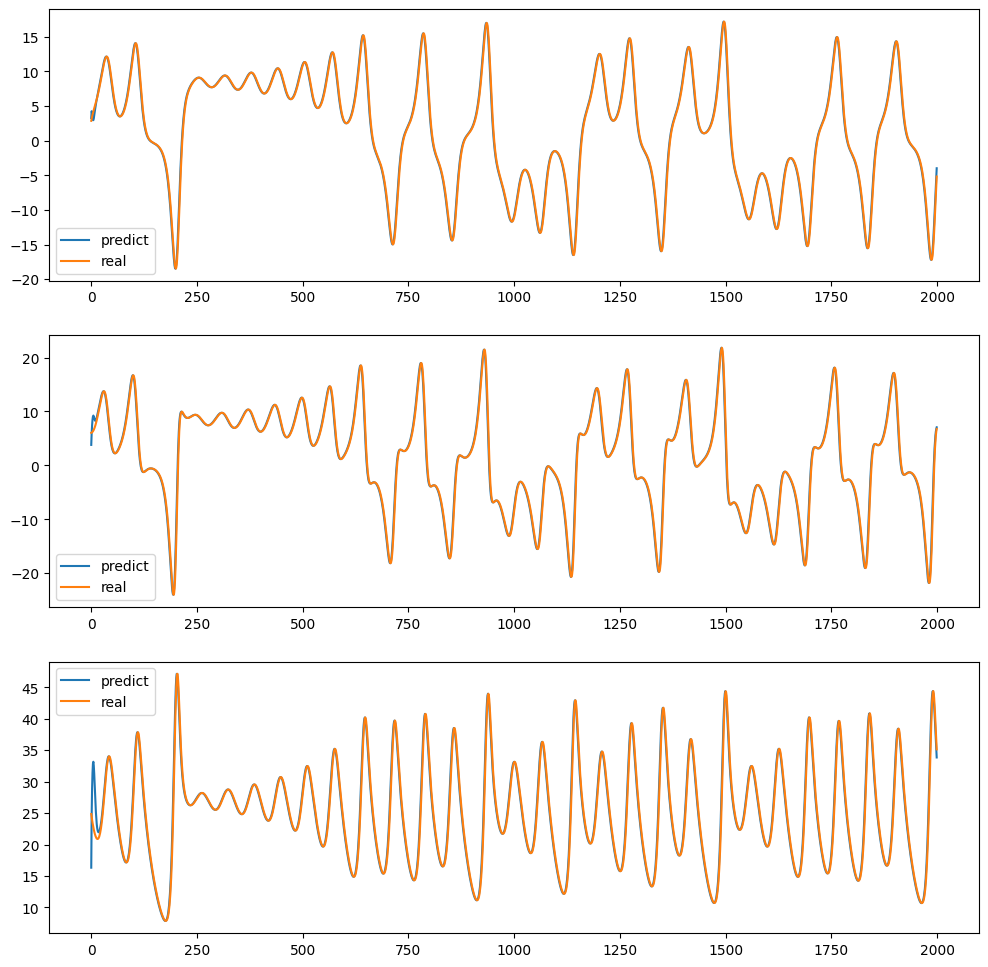

In [86]:
plt.figure(figsize=(12, 12))
plt.subplot(311)
ind = 0
plt.plot(output_test[0:20_00, ind], label='predict')
plt.plot(lorenz_data[Ttrian:Ttrian + 20_00, ind], label='real')
plt.legend()

plt.subplot(312)
ind = 1
plt.plot(output_test[0:20_00, ind], label='predict')
plt.plot(lorenz_data[Ttrian:Ttrian + 20_00, ind], label='real')
plt.legend()

plt.subplot(313)
ind = 2
plt.plot(output_test[0:20_00, ind], label='predict')
plt.plot(lorenz_data[Ttrian:Ttrian + 20_00, ind], label='real')
plt.legend()
plt.show()

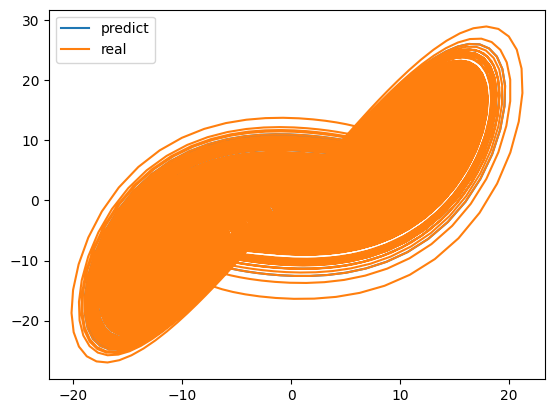

In [84]:
plt.figure()
plt.plot(output_test[:, 0], output_test[:, 1], label='predict')
plt.plot(lorenz_data[:, 0], lorenz_data[:, 1], label='real')
plt.legend()
plt.legend()
plt.show()